In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

#Import Qiskit classes
import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the qv function
import qiskit.ignis.verification.quantum_volume as qv

**Step 1: Generate QV sequences**

In the following example we have 6 qubits Q0,Q1,Q3,Q5,Q7,Q10. We are going to look at subsets up to the full set (each volume circuit will be depth equal to the number of qubits in the subset).

In [9]:
# qubit_lists: list of list of qubit subsets to generate QV circuits
qubit_lists = [[0,1,3],[0,1,3,5],[0,1,3,5,7],[0,1,3,5,7,10]]
# ntrials: Number of random circuits to create for each subset
ntrials = 100

We generate the quantum volume sequences. We start with a small example (so it doesn't take too long to run).

In [10]:
import warnings
warnings.filterwarnings('ignore')
qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists, ntrials)

As an example, we print the circuit corresponding to the first QV sequence. Note that the ideal circuits are run on the first n qubits (where n is the number of qubits in the subset).

In [11]:
# pass the first trial of the nomeas through the transpiler to illustrate the circuit
qv_circs_nomeas[0] = qiskit.compiler.transpile(qv_circs_nomeas[0], basis_gates=['u1','u2','u3','cx'])

In [12]:
qv_circs_nomeas[0][0].draw(fold=-1)

global phase: 2.7077
     ┌────────────────────────────┐┌───┐┌────────────────────────────┐┌───┐┌───────────────────────────┐┌───┐┌────────────────────────────┐┌───┐┌────────────────────────────┐┌───┐┌───────────────────────────┐┌───┐┌───────────────────────────┐        ┌──────────────────────┐           ┌─────────────────────┐        ┌────────────────────────────┐
q_0: ┤ U3(0.46782,-1.0711,1.4297) ├┤ X ├┤ U3(1.0507,0.52698,0.70689) ├┤ X ├┤ U3(2.0899,2.6136,-2.4368) ├┤ X ├┤ U3(3.0126,-2.9415,-1.2181) ├┤ X ├┤ U3(0.85534,0.11249,1.4002) ├┤ X ├┤ U3(2.0899,2.6136,-2.4368) ├┤ X ├┤ U3(1.2872,-1.8024,2.6426) ├──■─────┤ U3(0.74785,-π/2,π/2) ├─────■─────┤ U3(0.053995,-π,π/2) ├─────■──┤ U3(0.9218,2.9152,-0.53837) ├
     └┬──────────────────────────┬┘└─┬─┘└──┬──────────────────────┬──┘└─┬─┘└──┬─────────────────────┬──┘└─┬─┘├────────────────────────────┤└─┬─┘└────────────────────────────┘└─┬─┘└───────────────────────────┘└─┬─┘└───────────────────────────┘┌─┴─┐┌──┴──────────────────────┴──┐┌─┴─┐┌──┴─────────────────────┴──┐┌─┴─┐├───────────────────────────┬┘
q_1: ─┤ U3(2.5797,2.0183,1.1996) ├───■─────┤ U3(0.86036,-π/2,π/2) ├─────■─────┤ U3(0.023002,-π,π/2) ├─────■──┤ U3(0.79726,1.7384,-0.7923) ├──┼──────────────────────────────────┼─────────────────────────────────┼───────────────────────────────┤ X ├┤ U3(1.0723,0.54729,0.66524) ├┤ X ├┤ U3(2.0899,2.6136,-2.4368) ├┤ X ├┤ U3(1.1631,2.1494,0.12073) ├─
     ┌┴──────────────────────────┴┐        └──────────────────────┘           └─────────────────────┘        └────────────────────────────┘  │     ┌──────────────────────┐     │     ┌──────────────────────┐    │  ┌───────────────────────────┐└───┘└────────────────────────────┘└───┘└───────────────────────────┘└───┘└───────────────────────────┘ 
q_2: ┤ U3(0.26782,-1.4674,1.5617) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────■─────┤ U3(0.78136,-π/2,π/2) ├─────■─────┤ U3(0.0049638,-π,π/2) ├────■──┤ U3(1.2159,-1.9194,1.1457) ├────────────────────────────────────────────────────────────────────────────────────────────────────────
     └────────────────────────────┘                                                                                                                └──────────────────────┘           └──────────────────────┘       └───────────────────────────┘

**Step 2: Simulate the ideal QV circuits**

The quantum volume method requires that we know the ideal output for each circuit, so we use the Aer simulator to get the ideal result.

In [13]:
sv_sim = qiskit.Aer.get_backend('aer_simulator')
ideal_results = []
for trial in range(ntrials):
    clear_output(wait=True)
    for qc in qv_circs_nomeas[trial]:
        qc.save_statevector()
    result = qiskit.execute(qv_circs_nomeas[trial], backend=sv_sim).result()
    ideal_results.append(result)
    print(f'Simulated trial {trial+1}/{ntrials}')

Simulated trial 100/100


Next, we load the ideal results into a quantum volume fitter

In [14]:
qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)

**Step 3: Calculate the heavy outputs**

As an illustration, we print the heavy outputs from various depths and their probabilities (for trial 0):

In [15]:
for qubit_list in qubit_lists:
    l = len(qubit_list)
    print ('qv_depth_'+str(l)+'_trial_0:', qv_fitter._heavy_outputs['qv_depth_'+str(l)+'_trial_0'])

qv_depth_3_trial_0: ['010', '011', '100', '110']
qv_depth_4_trial_0: ['0000', '0001', '0011', '0111', '1000', '1010', '1011', '1111']
qv_depth_5_trial_0: ['00010', '00011', '00100', '00101', '00110', '00111', '01011', '01100', '01101', '01110', '01111', '10000', '11001', '11011', '11110', '11111']
qv_depth_6_trial_0: ['000000', '000011', '000100', '000101', '000110', '000111', '001000', '001001', '001010', '001100', '001110', '010001', '010010', '010110', '010111', '011000', '011001', '011010', '011101', '011110', '100000', '100010', '100011', '100110', '101100', '110010', '110100', '110101', '110111', '111100', '111101', '111111']


In [16]:
for qubit_list in qubit_lists:
    l = len(qubit_list)
    print ('qv_depth_'+str(l)+'_trial_0:', qv_fitter._heavy_output_prob_ideal['qv_depth_'+str(l)+'_trial_0'])

qv_depth_3_trial_0: 0.8711716544781744
qv_depth_4_trial_0: 0.829774868953036
qv_depth_5_trial_0: 0.8543419735543087
qv_depth_6_trial_0: 0.8234087763709976


**Step 4: Define the noise model**

We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [17]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.02
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

We can execute the QV sequences either using Qiskit Aer Simulator (with some noise model) or using IBMQ provider, and obtain a list of exp_results.

In [18]:
aer_sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 1024
exp_results = []
for trial in range(ntrials):
    clear_output(wait=True)
    t_qcs = transpile(qv_circs[trial], basis_gates=basis_gates, optimization_level=3)
    qobj = assemble(t_qcs)
    result = aer_sim.run(qobj, noise_model=noise_model, max_parallel_experiments=0).result()
    exp_results.append(result)
    print(f'Completed trial {trial+1}/{ntrials}')

Completed trial 100/100


**Step 5: Calculate the average gate fidelity**

As an illustration, we print the heavy output counts from various depths (for trial 0):

In [19]:
qv_fitter.add_data(exp_results)
for qubit_list in qubit_lists:
    l = len(qubit_list)
    print ('qv_depth_'+str(l)+'_trial_0:', qv_fitter._heavy_output_counts['qv_depth_'+str(l)+'_trial_0'])

qv_depth_3_trial_0: 832
qv_depth_4_trial_0: 686
qv_depth_5_trial_0: 767
qv_depth_6_trial_0: 671


**Step 6: Calculate the achievable depth**

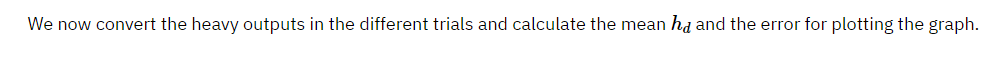

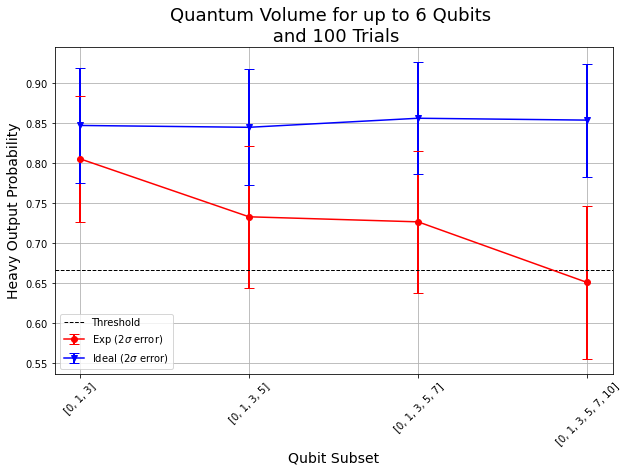

In [20]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the essence by calling plot_rb_data
qv_fitter.plot_qv_data(ax=ax, show_plt=False)

# Add title and label
ax.set_title('Quantum Volume for up to %d Qubits \n and %d Trials'%(len(qubit_lists[-1]), ntrials), fontsize=18)

plt.show()

**Step 7: Calculate the Quantum Volume**

We list the statistics for each depth. For each depth we list if the depth was successful or not and with what confidence interval. For a depth to be successful the confidence interval must be > 97.5%.

In [21]:
qv_success_list = qv_fitter.qv_success()
qv_list = qv_fitter.ydata
QV = 1
for qidx, qubit_list in enumerate(qubit_lists):
    if qv_list[0][qidx]>2/3:
        if qv_success_list[qidx][0]:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (successful). Quantum volume %d"%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1],qv_fitter.quantum_volume()[qidx]))
            QV = qv_fitter.quantum_volume()[qidx]
        else:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (unsuccessful)."%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1]))
    else:
        print("Width/depth %d less than 2/3 (unsuccessful)."%len(qubit_list))

Width/depth 3 greater than 2/3 (0.805469) with confidence 0.999773 (successful). Quantum volume 8
Width/depth 4 greater than 2/3 (0.732861) with confidence 0.932679 (unsuccessful).
Width/depth 5 greater than 2/3 (0.726543) with confidence 0.910416 (unsuccessful).
Width/depth 6 less than 2/3 (unsuccessful).


In [22]:
print ("The Quantum Volume is:", QV) 

The Quantum Volume is: 8
